In [1]:
!pip install transformers
import pandas as pd
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Load a sample dataset
df = pd.read_csv('IMDB Dataset.csv')

# Preprocessing: Convert labels to binary (0 for 'negative', 1 for 'positive')
df['binary_sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Split the data into training, validation, and testing sets
X = df['review'].values
y = df['binary_sentiment'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Tokenize and encode the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt', max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt', max_length=128)

# Create DataLoader objects
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=32)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training and evaluation loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 3  # Adjust this as needed
for epoch in range(epochs):
    # Training Phase
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training', leave=False)
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': total_loss / (batch[0].shape[0] + 1)})

    # Validation Phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_true_labels = []
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation', leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)

            val_loss += loss.item()
            val_predictions.extend(predicted_labels.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Visualize Attention Weights
def plot_attention(attention, sentence, model_name):
    fig, ax = plt.subplots(figsize=(8, 8))
    attention = attention.squeeze(0)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 10}
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(sentence)))
    ax.set_xticklabels(sentence, rotation=90, fontdict=fontdict)
    ax.set_yticklabels(sentence, fontdict=fontdict)
    ax.set_title(f'Attention Map - {model_name}')
    plt.show()

# Extract and visualize attention weights from XLNet
sentence = "I love the movie!"
tokens = tokenizer.tokenize(sentence)
inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)
inputs = {k: v.to(device) for k, v in inputs.items()}



Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 1/3 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/3 - Validation Loss: 0.2516, Validation Accuracy: 0.8952


Epoch 2/3 - Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2/3 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/3 - Validation Loss: 0.2320, Validation Accuracy: 0.8986


Epoch 3/3 - Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/3 - Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/3 - Validation Loss: 0.2670, Validation Accuracy: 0.9048


TypeError: ignored

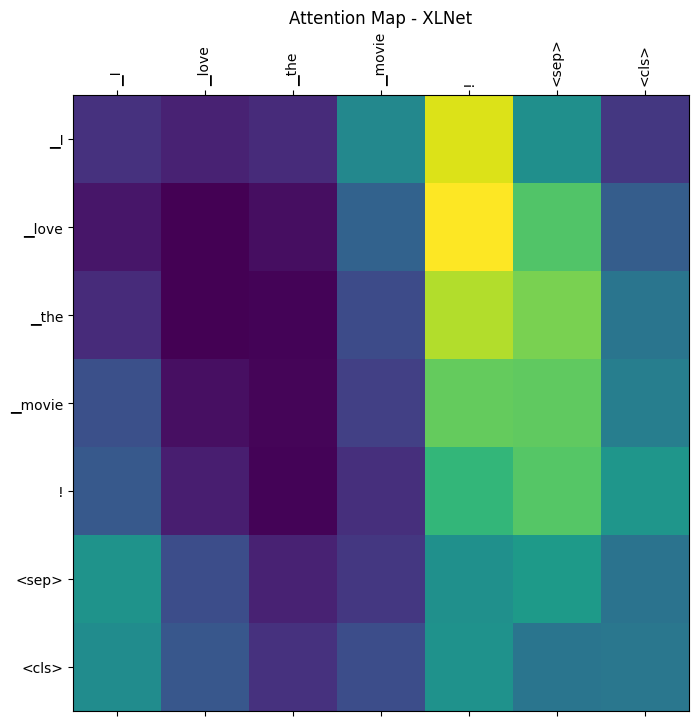

In [3]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attention = outputs.attentions[-1][0]  # get last layer's attention
  # get last layer's attention
plot_attention(attention[0].cpu(), tokens + ["<sep>", "<cls>"], "XLNet")
